# Group-Sequential Testing by Permutation

This notebook contains simulations to show that the permutation-based approach to group-sequential testing used in this package effectively controls the false-positive rate, even when analyzing the data sequentially (i.e. stopping data collection when the pattern of interest is significant, and continuing otherwise). 

In these simulations, we apply the permutation scheme to univariate data for ease of computation -- but the nice thing about permutation tests is that they can be used on arbitrary test statistics, so the results here should generalize to e.g. a cluster statistic. To perform permutations and compute adjusted thresholds, we'll use the same `generate_permutation_dist` and `find_thresholds` functions used on the backend of `niseq` so we can be sure the exact same permutation scheme is being used.

## How it Works

In [1]:
from niseq._permutation import generate_permutation_dist, find_thresholds
from matplotlib import pyplot as plt
import numpy as np

Let's start by simulating some data, and then taking draws from the permutation distribution. An important difference between this sequential permutation approach and a typical permutation test is that the sequential looks at the data are incorporated into the permutation procedure. For instance, if we use `look_times = [50, 100]`, indicating we peak at the data when the sample size is $n = 50$ and $n = 100$, then the test statistic will be computed for just the first 50 and the first 100 samples on each permutation, simulating multiple looks at the data. Thus, the permutation distribution generated is a _joint_ null distribution that accounts for the dependency between sequential looks (since examples are shared across looks). The `generate_permutation_dist` function, which is one of the backend functions for the cluster-based tests in `niseq`, will generate this permutation distribution for us.

In [2]:
# simulate null data
np.random.seed(0)
look_times = np.linspace(20, 250, 5).astype(int)
x = np.random.normal(loc = 0, size = look_times[-1])

obs, H0 = generate_permutation_dist(
    x, None,
    look_times = look_times, 
    statistic = lambda x: np.mean(x[0])
)

The `find_thresholds` function, another backend function used by `niseq`, figures out what adjusted significance thresholds must be used at each look time to contain the false positive rate at your chosen $\alpha$ for the whole procedure. We can't let the false positive rate for the first look be $\alpha$, or adding additional looks will drive the false positive rate upwards of $\alpha$ for the full procedure. This is where an alpha spending function comes in: it defines a target for false positive rate by each look time. So if $\text{spending}(50) = 0.01$, that means the false positive rate _up till now_ at $n = 50$ should be contained at $0.01$. By the end of the procedure, the false positive rate should be $\alpha$; that is, $\text{spending}(n_\text{max}) = \alpha$.

Let's say we look at the data five times during data collection, and we use a linear spending function. What are our resulting adjusted $\alpha$'s?

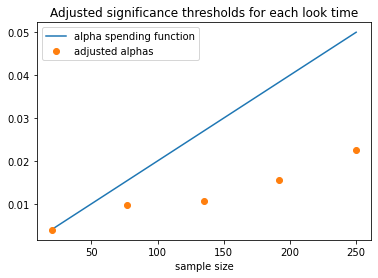

In [3]:
spending, adj_alpha = find_thresholds(H0, look_times, look_times[-1], tail = 0)
plt.plot(look_times, spending, label = 'alpha spending function')
plt.plot(look_times, adj_alpha, 'o', label = 'adjusted alphas')
plt.xlabel('sample size')
plt.title('Adjusted significance thresholds for each look time')
plt.legend()
plt.show()

You'll notice the adjusted thresholds at each $n$ are less than the alpha spending function at $n$, except for the first look. This is because some data are shared across sequential looks, so we need to account for the dependency between rejecting at $n_i$ and $n_j$, which is what our permutation procedure is doing -- `find_thresholds` picks rejection thresholds for each look time that maintains the false positive rate _up till_ each look at the alpha spending function, given all the previous looks.

In the plot above (and in the simulations below), we use a linear alpha spending function, the default used by `find_thresholds`, but any monotonically increasing function such that $\text{spending}(0) = 0$ and $\text{spending}(n_\text{max}) = \alpha$ would work. Also, while we used evenly spaced look times, we could actually pick any arbitrary look times, and in practice, we don't even need to plan when we're going to peak at the data ahead of time!

## One Sample Test

On each simulation below, we'll generate null data and pretend we look at it five times throughout the intended course of data collection, and we'll compare the false positive rates attained when we reject the null hypothesis whenever $p \leq \alpha$ and $p \leq \alpha_\text{adjusted}$ at at least one look time.

In [4]:
np.random.seed(0)
look_times = np.linspace(20, 100, 5).astype(int)
n_simulations = 5000
unadj_ct = 0
adj_ct = 0

for i in range(n_simulations):
    
    if i % 100 == 0:
        print('%d/%d simulations complete'%(i, n_simulations))
    
    # generate null data 
    x = np.random.normal(loc = 0, size = look_times[-1])
    
    # and compute permutation distribution
    obs, H0 = generate_permutation_dist(
        x, None,
        look_times = look_times, 
        statistic = lambda _x: np.mean(_x[0]),
        n_permutations = 5000
    )
    
    # compute p-values for each look time
    obs_stats = np.array([obs[n] for n in look_times])
    p = (np.abs(H0) >= np.abs(obs_stats)).mean(0)
    
    # and find the adjusted significance thresholds
    # for each look
    spending, adj_alpha = find_thresholds(
        H0, look_times, 
        look_times[-1], 
        tail = 0
    )
    
    # reject if p-val crosses sig threshold at any look time
    unadj_ct += np.any(p < .05) # keep count of uncorrected 
    adj_ct += np.any(p < adj_alpha) # and corrected rejections 
    

0/5000 simulations complete
100/5000 simulations complete
200/5000 simulations complete
300/5000 simulations complete
400/5000 simulations complete
500/5000 simulations complete
600/5000 simulations complete
700/5000 simulations complete
800/5000 simulations complete
900/5000 simulations complete
1000/5000 simulations complete
1100/5000 simulations complete
1200/5000 simulations complete
1300/5000 simulations complete
1400/5000 simulations complete
1500/5000 simulations complete
1600/5000 simulations complete
1700/5000 simulations complete
1800/5000 simulations complete
1900/5000 simulations complete
2000/5000 simulations complete
2100/5000 simulations complete
2200/5000 simulations complete
2300/5000 simulations complete
2400/5000 simulations complete
2500/5000 simulations complete
2600/5000 simulations complete
2700/5000 simulations complete
2800/5000 simulations complete
2900/5000 simulations complete
3000/5000 simulations complete
3100/5000 simulations complete
3200/5000 simulation

In [5]:
# false positive rate without correction
unadj_ct / n_simulations

0.1432

If we don't correct for sequential looks using our alpha spending approach, rejecting the null and stopping data collection as soon as we see $p \leq 0.05$ but continuing to collect data otherwise, we end up with an inflated false positive rate. Let's see how our alpha spending procedure fares by comparison:

In [6]:
# false positive rate with correction
adj_ct / n_simulations

0.0496

Great! We've contained the false positive rate below our specified $\alpha$, even while peaking at the data to decide whether to stop data collection. Thus, as long as we can specify a reasonable $n_\text{max}$ we're willing to collect, we can use this procedure to determine our sample size adaptively!

## Independent Sample Test

In [7]:
np.random.seed(0)
unadj_ct = 0
adj_ct = 0

for i in range(n_simulations):
    
    if i % 100 == 0:
        print('%d/%d simulations complete'%(i, n_simulations))
    
    # generate null data 
    x = np.random.normal(loc = 0, size = look_times[-1])
    conds = np.random.choice([0, 1], look_times[-1])
    
    # and compute permutation distribution
    obs, H0 = generate_permutation_dist(
        x, conds,
        look_times = look_times, 
        statistic = lambda _x: np.mean(_x[0]),
        n_permutations = 5000
    )
    
    # compute p-values for each look time
    obs_stats = np.array([obs[n] for n in look_times])
    p = (np.abs(H0) >= np.abs(obs_stats)).mean(0)
    
    # and find the adjusted significance thresholds
    # for each look
    spending, adj_alpha = find_thresholds(
        H0, look_times, 
        look_times[-1], 
        tail = 0
    )
    
    # reject if p-val crosses sig threshold at any look time
    unadj_ct += np.any(p < .05) # keep count of uncorrected 
    adj_ct += np.any(p < adj_alpha) # and corrected rejections 
    

0/5000 simulations complete
100/5000 simulations complete
200/5000 simulations complete
300/5000 simulations complete
400/5000 simulations complete
500/5000 simulations complete
600/5000 simulations complete
700/5000 simulations complete
800/5000 simulations complete
900/5000 simulations complete
1000/5000 simulations complete
1100/5000 simulations complete
1200/5000 simulations complete
1300/5000 simulations complete
1400/5000 simulations complete
1500/5000 simulations complete
1600/5000 simulations complete
1700/5000 simulations complete
1800/5000 simulations complete
1900/5000 simulations complete
2000/5000 simulations complete
2100/5000 simulations complete
2200/5000 simulations complete
2300/5000 simulations complete
2400/5000 simulations complete
2500/5000 simulations complete
2600/5000 simulations complete
2700/5000 simulations complete
2800/5000 simulations complete
2900/5000 simulations complete
3000/5000 simulations complete
3100/5000 simulations complete
3200/5000 simulation

In [8]:
# false positive rate without correction
unadj_ct / n_simulations

0.1466

In [9]:
# false positive rate with correction
adj_ct / n_simulations

0.049